In [1]:
from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from nilearn import image

### Define file names and dirs

In [2]:
dir_ = Path('neurocovid_derivatives')
subjects = [subdir for subdir in dir_.iterdir() if subdir.is_dir() and subdir.name.startswith('sub-')]
func_filename      = '_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
aroma_filename     = '_task-rest_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'
confounds_filename = '_task-rest_desc-confounds_timeseries.tsv'

subj_funcdata  = [Path(subj_path, 'func', f'{subj_path.name}{func_filename}') for subj_path in subjects]
subj_aromadata = [Path(subj_path, 'func', f'{subj_path.name}{aroma_filename}') for subj_path in subjects]
subj_confounds = [Path(subj_path, 'func', f'{subj_path.name}{confounds_filename}') for subj_path in subjects]

# Extracting time series to build a functional connectome
## Brain parcellation
Fetch brain atlas (regions' labels and coords)

['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R']


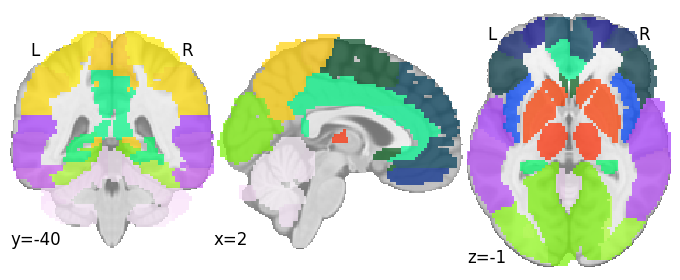

In [3]:
from nilearn import datasets
atlas_aal = datasets.fetch_atlas_aal() # secciona bien el hipocampo (buena para memoria), discreto
atlas_maps = atlas_aal.maps
plotting.plot_roi(atlas_maps, draw_cross=False, annotate=True)
# load labels for each atlas region
labels = atlas_aal.labels
print(labels[:10])

### Extracting signals on a parcellation
#### Usando todos los confounds

In [4]:
from nilearn.maskers import NiftiLabelsMasker
masker_allconf = NiftiLabelsMasker(labels_img=atlas_maps, 
                                    smoothing_fwhm=6,
                                    t_r=2., 
                                    standardize=False,
                                    detrend=True,
                                    memory='nilearn_cache', memory_level=2)

#### Usando "simple strategy"

In [4]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_maps,
                           smoothing_fwhm=6,
                           low_pass=0.08,
                           high_pass=0.01,
                           t_r=2.,
                           standardize=False,
                           detrend=True,
                           memory='nilearn_cache', memory_level=2)

#### Usando ICA-AROMA

In [6]:
from nilearn.maskers import NiftiLabelsMasker
masker_aroma = NiftiLabelsMasker(labels_img=atlas_maps,
                                # smoothing_fwhm=6,
                                low_pass=0.08,
                                high_pass=0.01,
                                t_r=2.,
                                standardize=False,
                                detrend=True,
                                memory='nilearn_cache', memory_level=2)

#### Start working with subjects' data

In [5]:
subj = 0

#### Mask all confounds

In [6]:
time_series_allconf = masker_allconf.fit_transform(str(subj_funcdata[subj]), confounds=str(subj_confounds[subj]))

NameError: name 'masker_allconf' is not defined

#### Mask "simple strategy"

In [7]:
from nilearn.interfaces import fmriprep
subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_funcdata[subj]))
time_series = masker.fit_transform(str(subj_funcdata[subj]), confounds=subj_confounds, sample_mask=subj_sample_mask)

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,


#### Mask ICA-Aroma

In [10]:
from nilearn.interfaces import fmriprep
subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_aromadata[subj]), denoise_strategy='ica_aroma')
time_series_aroma = masker.fit_transform(str(subj_aromadata[subj]), confounds=subj_confounds, sample_mask=subj_sample_mask)

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: UserWarning: Persisting input arguments took 1.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,


### Correlation matrix

#### All confounds

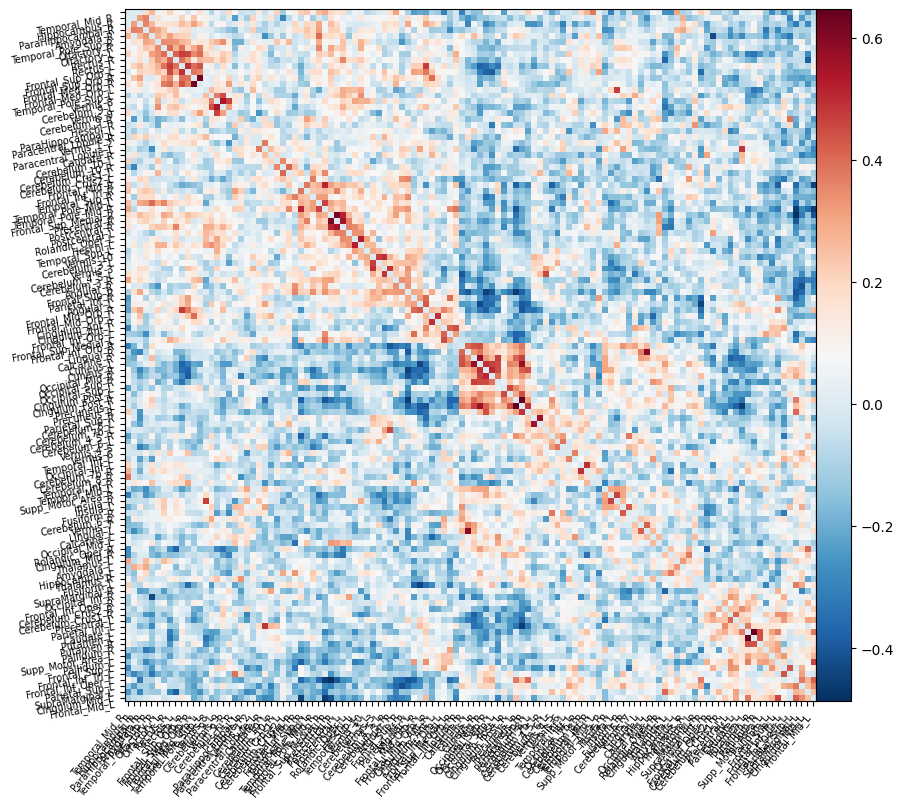

In [11]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_allconf = correlation_measure.fit_transform([time_series_allconf])[0]
np.fill_diagonal(correlation_matrix_allconf, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(correlation_matrix_allconf, figure=(10, 8), labels=labels,
                     reorder=True)

#### "Simple strategy"

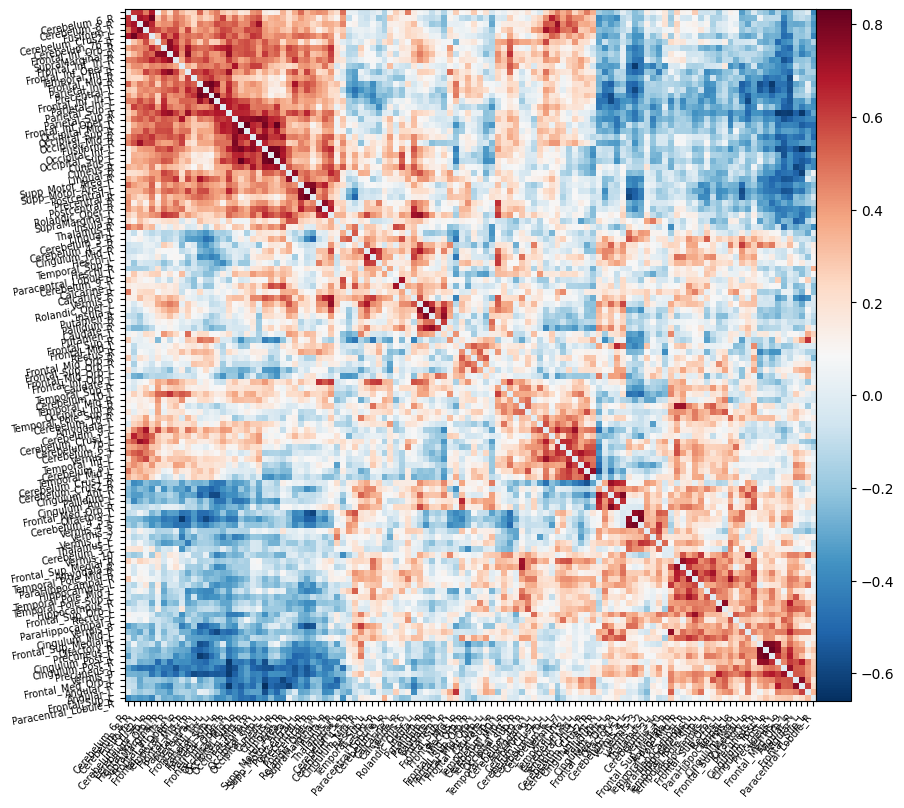

In [8]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
np.fill_diagonal(correlation_matrix, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     reorder=True)

#### ICA-Aroma

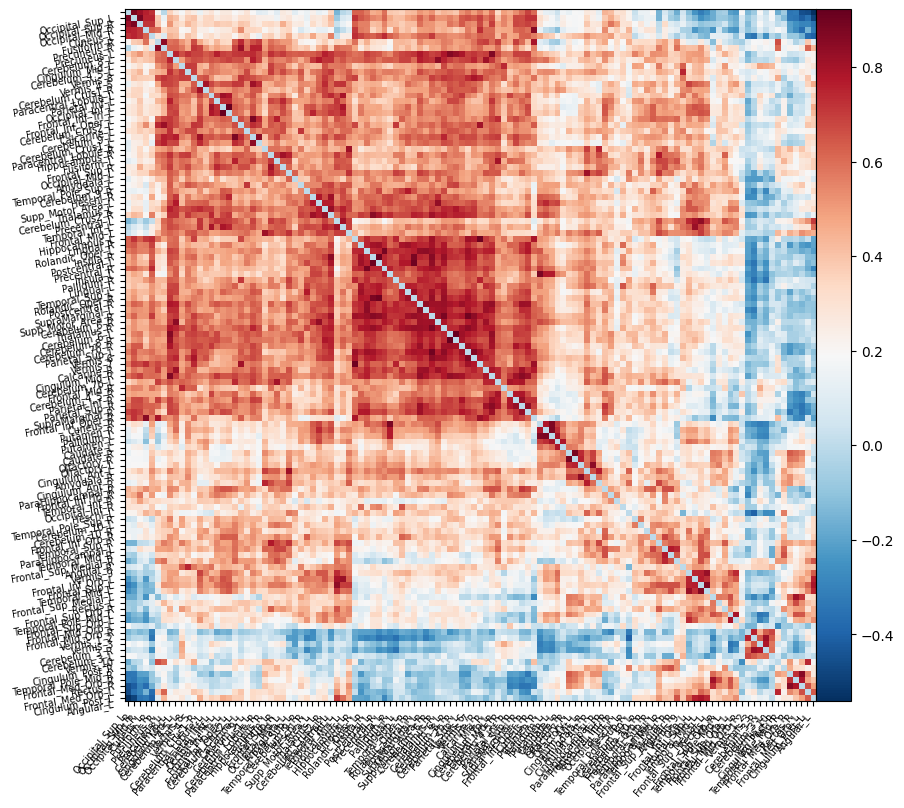

In [13]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_aroma = correlation_measure.fit_transform([time_series_aroma])[0]
np.fill_diagonal(correlation_matrix_aroma, 0)
plotting.plot_matrix(correlation_matrix_aroma, figure=(10, 8), labels=labels,
                     reorder=True)

### Functional connectome

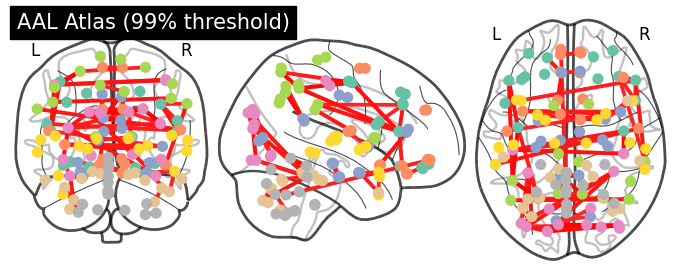

In [13]:
""" No tenemos las coordenadas del atlas, las buscamos """
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_maps)
plotting.plot_connectome(correlation_matrix, coordinates, edge_threshold='99%', title='AAL Atlas (99% threshold)')

## Default Mode Network nodes (MSDL atlas)

/home/ftravi/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


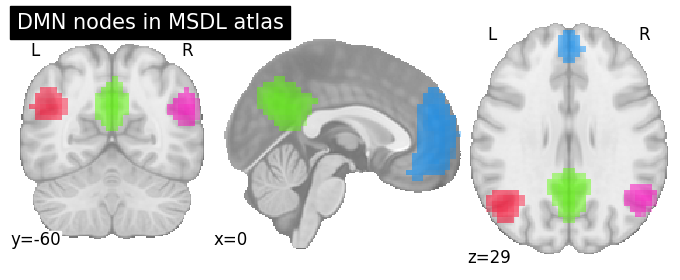

In [14]:
atlas = datasets.fetch_atlas_msdl()

# Default Mode Network nodes for MSDL atlas
dmn_nodes = image.index_img(atlas.maps, [3, 4, 5, 6])

# Plot MSDL probability atlas
# To only plot DMN nodes, replace 'atlas.maps' with 'dmn_nodes' and add dmn_cutcoords
dmn_cutcoords = (0, -60, 29)
plotting.plot_prob_atlas(dmn_nodes, cut_coords=dmn_cutcoords, draw_cross=False,
                         annotate=True, title="DMN nodes in MSDL atlas")

In [19]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas.maps,
                         smoothing_fwhm=6,
                         high_pass=0.01,
                         low_pass=0.08,
                         t_r=2.,
                         standardize=False, # fMRI prep ya normaliza
                         detrend=True,
                         memory="nilearn_cache", memory_level=2)

In [20]:
from nilearn.interfaces import fmriprep
subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_funcdata[subj]))

probtime_series = masker.fit_transform(str(subj_funcdata[subj]), confounds=subj_confounds, sample_mask=subj_sample_mask)
prob_correlation_matrix = correlation_measure.fit_transform([probtime_series])[0]
np.fill_diagonal(prob_correlation_matrix, 0)

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_maps_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,


In [21]:
prob_labels = atlas.labels
if len(prob_labels) != len(prob_correlation_matrix):
    diff = abs(len(prob_labels) - len(prob_correlation_matrix))
    prob_labels = prob_labels[diff:]

In [22]:
if 'region_coords' in atlas:
    prob_coords = atlas.region_coords
else:
    prob_coords = plotting.find_probabilistic_atlas_cut_coords(atlas.maps)    

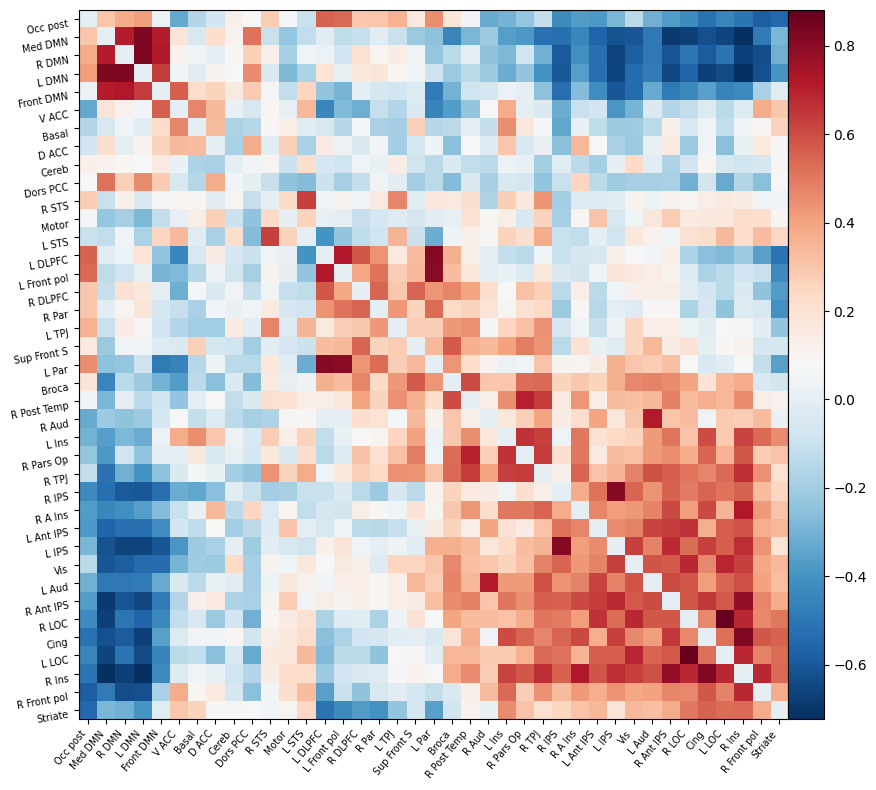

In [23]:
plotting.plot_matrix(prob_correlation_matrix, figure=(10, 8), labels=prob_labels, reorder=True)

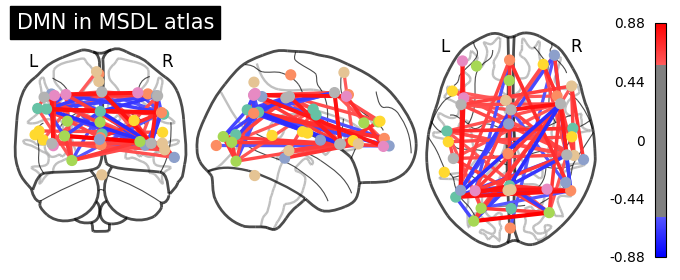

In [25]:
plotting.plot_connectome(prob_correlation_matrix, prob_coords, edge_threshold='90%', colorbar=True, title='DMN in MSDL atlas')

In [26]:
plotting.view_connectome(prob_correlation_matrix, prob_coords, edge_threshold='90%', edge_cmap='bwr',
                         symmetric_cmap=True, linewidth=6.0, node_size=3.0)

# Maps of seed-to-voxel correlation
### Time series extraction
First, we need to extract the time series from the seed region. For this example, let’s specify a sphere of radius 8 (in mm) located in the Posterior Cingulate Cortex. This sphere is considered to be part of the Default Mode Network.

In [27]:
# Sphere radius in mm
sphere_radius = 8

# Sphere center in MNI-coordinate
sphere_coords = [(0, -52, 18)]

In [47]:
from nilearn.input_data import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker(sphere_coords,
                                 smoothing_fwhm=6,
                                 radius=sphere_radius, 
                                 standardize=True,
                                 detrend=True,
                                 t_r=2.,
                                 high_pass=0.01,
                                 low_pass=0.08,
                                 memory="nilearn_cache", memory_level=2)

Extract the mean time series within the seed region

**Acá fue necesario estandarizar para poder realizar la comparación**

Al instanciar las máscaras con los parámetros *low_pass* y *high_pass*, da puro ruido al usar todos los confounds. Quitarlos da los resultados vistos más abajo. ¿Esto significa que los confounds ya realizan filtrado de señales?

In [48]:
from nilearn.interfaces import fmriprep
subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_funcdata[subj]))
seed_time_series = seed_masker.fit_transform(str(subj_funcdata[subj]), confounds=subj_confounds, sample_mask=subj_sample_mask)

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_spheres_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: UserWarning: Persisting input arguments took 0.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,


A similar procedure needs to be done for each voxel in the brain as well. We use NiftiMasker again

In [49]:
from nilearn.input_data import NiftiMasker
brain_masker = NiftiMasker(smoothing_fwhm=6,
                           t_r=2.,
                           high_pass=0.01,
                           low_pass=0.08,
                           standardize=True, 
                           detrend=True,
                           memory="nilearn_cache", memory_level=2)

We extract the time series for every voxel

In [50]:
brain_time_series = brain_masker.fit_transform(str(subj_funcdata[subj]), confounds=subj_confounds, sample_mask=subj_sample_mask)

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:112: UserWarning: Persisting input arguments took 0.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,


### Perform seed-based correlation analysis
Now that we have two arrays (mean signal in seed region, signal for each voxel), we can correlate the two to each other. This can be done with the dot product between the two matrices.

In [51]:
seed_based_correlations = np.dot(brain_time_series.T, seed_time_series)
seed_based_correlations /= seed_time_series.shape[0]

### Plot the seed-based correlation map
We transform the correlation array back to a Nifti image

In [52]:
seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations.T)

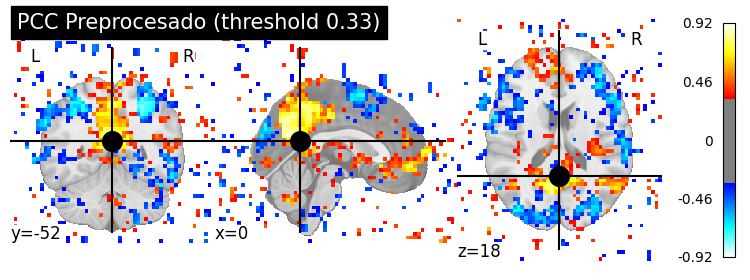

In [53]:
display = plotting.plot_stat_map(seed_based_correlation_img, threshold=0.33,
                                 cut_coords=sphere_coords[0], title='PCC Preprocesado (threshold 0.33)')
display.add_markers(marker_coords=sphere_coords, marker_color='black',
                    marker_size=200)